### PAVICS WPS workflow 
##### In this example we will chain PAVICS wps calls together to create a hypothetical data analysis workflow
We will try to accomplish the following tasks - all carried out on the PAVICS server:
1. search for netcdf files using the PAVICS catalogue (we'll use some ClimEX data)
* spatially subset the data for a zone over southern Quebec
* temporally concatenate subsetted files into a single time-series
* calculate a climate index (monthly maximum)
* download the resulting .nc locally and make a plot 

In this example we will use three different PAVICS WPS suites
* PAVICS catalogue : https://pavics.ouranos.ca/twitcher/ows/proxy/catalog/pywps
* Flyingpigeon suite : https://pavics.ouranos.ca/twitcher/ows/proxy/flyingpigeon/wps 
* Hummingbird suite : https://pavics.ouranos.ca/twitcher/ows/proxy/hummingbird/wps


#### Imports


In [ ]:
from owslib.wps import WebProcessingService
from netCDF4 import Dataset
import requests
import xml.etree.ElementTree as ET   
import matplotlib.pyplot as plt


####1 - search for datasets using the Catalogue

In [2]:
# catalogue WPS url
wpsURL = 'https://pavics.ouranos.ca/twitcher/ows/proxy/catalog/pywps'

# Connection 
wpsCatalogue = WebProcessingService(url=wpsURL)

##### 1.1 List available catalogue processes

In [3]:
for process in wpsCatalogue.processes:
    print ('%s \t : %s \n' %(process.identifier, process.abstract))

getpoint 	 : Return a single value from a NetCDF file at the given grid coordinates. 

ncplotly 	 : Return a dictionary storing the data necessary to create a simple plotly time series. 

pavicrawler 	 : Crawl thredds server and write metadata to SOLR database. 

pavicsearch 	 : Search the PAVICS database and return a catalogue of matches. 

pavicsupdate 	 : Update database entries using key:value pairs and identified by their ids. 

pavicsvalidate 	 : Query database entries for missing required facets. 

period2indices 	 : The final index is inclusive. 

pavicstestdocs 	 : Add test documents to Solr index. 



#####1.2 we want the 'pavicsearch' process
* let's describe the process first 

In [4]:
proc_name = 'pavicsearch'
process = wpsCatalogue.describeprocess(proc_name) # get process info
for i in process.dataInputs:
    print('inputs :', i.identifier, ' : ', i.abstract)
for i in process.processOutputs:
    print('outputs :', i.identifier, ' : ', i.abstract)

inputs : facets  :  Comma separated list of facets; facets are searchable indexing terms in the database.
inputs : shards  :  Shards to be queried
inputs : offset  :  Where to start in the document count of the database search.
inputs : limit  :  Maximum number of documents to return.
inputs : fields  :  Comme separated list of fields to return.
inputs : format  :  Output format.
inputs : query  :  Direct query to the database.
inputs : distrib  :  Distributed query
inputs : type  :  One of Dataset, File, Aggregate or FileAsAggregate.
inputs : constraints  :  Format is facet1:value1,facet2:value2,...
inputs : esgf  :  Whether to also search ESGF nodes.
inputs : list_type  :  Can be opendap_url, fileserver_url, gridftp_url, globus_url, wms_url
outputs : search_result  :  PAVICS Catalogue Search Result
outputs : list_result  :  List of urls of the search result.


#####1.3 Search for ClimEx data - variable tasmax


In [6]:
# built Constraint string  variable = 'tasmax' and 'project ' = ClimEx 
constraintString = 'variable:tasmax,project:ClimEx'
maxfiles = '10000'
myinputs = [('constraints', constraintString),('type','File'), ('limit',maxfiles)]
execution = wpsCatalogue.execute(proc_name, myinputs)
print(execution.status)
print(execution.processOutputs[-1].reference)


ProcessSucceeded
None


In [14]:
# Same workaround here - execution.processOutputs[-1].reference is none (?)
o = requests.get(execution.statusLocation)
tree = ET.fromstring(o.content)
for child in tree:
    if 'ProcessOutputs' in child.tag:
        for c in child:
            if 'Output' in c.tag:
                for cc in c:
                    if 'Reference' in cc.tag:
                        r = requests.get(cc.get('{http://www.w3.org/1999/xlink}href'))
                        #print(r.content)

list_nc = r.json()
print('Numer of files found :',len(list_nc), '\n')
print(list_nc[1:15],'...')

Numer of files found : 8700 

['https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_206005_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r2i1p1/tasmax/tasmax_kdb_202907_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_200310_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r3i1p1/tasmax/tasmax_kdc_209701_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r2i1p1/tasmax/tasmax_kdb_199110_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/his

#####1.4 There are multiple simulations - ids : 'kda','kdb' etc
* Filter the list for only 'kda'
* Get only a 1 year of data - 1981 
* Files are not in sequential order - use sort() to clean up the list


In [68]:
# filter netcdf_file list
kda_nc = [i for i in list_nc if 'kda' in i and '1981' in i ]
# sort the filtered list
kda_nc.sort()

print('Number of files :', len(kda_nc),kda_nc)



Number of files : 12 ['https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_198101_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_198102_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_198103_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_198104_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r1-r1i1p1/tasmax/tasmax_kda_198105_se.nc', 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/climex/QC11d3_CCCma-CanESM2_rcp85/day/historical-r

##### End step 1 - Successful search and filtering of datasets	

### Step 2 - spatial subset the ncfiles
* subetting functions can be found in Flyingpigeon 
* fist step initiate connection to flyingpigeon 


In [36]:
wpsURL = 'https://pavics.ouranos.ca/twitcher/ows/proxy/flyingpigeon/wps'
wpsFP = WebProcessingService(url=wpsURL,verbose=False, skip_caps=False)
print(wpsFP.identification.title)

Flyingpigeon 1.1_dev


##### 2.1 List available flyingpigeon processes

In [37]:
for process in wpsFP.processes:
    print ('%s \t : %s \n' %(process.identifier, process.abstract))

subset_countries 	 : Return the data whose grid cells intersect the selected countries for each input dataset. 

subset_continents 	 : Return the data whose grid cells intersect the selected continents for each input dataset. 

subset_regionseurope 	 : Return the data whose grid cells inteserct the selected regions for each input dataset. 

pointinspection 	 : Extract the timeseries at the given coordinates. 

landseamask 	 : Mask grid cells according to their land area fraction. This process uses the ESGF datastore to access an appropriate land/sea mask. 

fetch_resources 	 : Fetch data resources (limited to 50GB) to the local filesystem of the birdhouse compute provider. 

indices_percentiledays 	 : Climatological percentile for each day of the year computed over the entire dataset. 

indices_single 	 : Climate index calculated from one daily input variable. 

sdm_gbiffetch 	 : Species occurence search in Global Biodiversity              Infrastructure Facillity (GBIF) 

sdm_getindic

#####2.2 Flyingpigeon does a lot - use 'subset_bbox' process for now
* let's describe the process first

In [38]:
proc_name = 'subset_bbox'
process = wpsFP.describeprocess(proc_name) # get process info
for i in process.dataInputs:
    print('inputs :', i.identifier, ' : ', i.abstract)
for i in process.processOutputs:
    print('outputs :', i.identifier, ' : ', i.abstract)

inputs : resource  :  NetCDF files, can be OPEnDAP urls.
inputs : lon0  :  Minimum longitude.
inputs : lon1  :  Maximum longitude.
inputs : lat0  :  Minimum latitude.
inputs : lat1  :  Maximum latitude.
inputs : initial_datetime  :  Initial datetime for temporal subsetting.
inputs : final_datetime  :  Final datetime for temporal subsetting.
inputs : variable  :  Name of the variable in the NetCDF file.Will be guessed if not provided.
outputs : output  :  JSON file with link to NetCDF outputs.


#####2.3 Create WPS inputs and execute WPS
* This time we will have multiple 'resource' inputs 
* Subset first multiple .nc files with one WPS call 
* Subset only using lat lon bounds - other inputs left blank

In [47]:
myinputs = []
# To keep things reasonably quick : subset jan-april
for i in kda_nc[0:5]: 
    myinputs.append(('resource', i))
myinputs.append(('lon0', '-80.0'))
myinputs.append(('lon1', '-70.0'))
myinputs.append(('lat0', '44.0'))
myinputs.append(('lat1', '50'))
print(myinputs)

ProcessSucceeded
None
https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/b9ffafd8-b77b-11e8-9163-0242ac12000b.xml


In [48]:

execution = wpsFP.execute(proc_name, myinputs)
print(execution.status)
print(execution.processOutputs[-1].reference)
print(execution.statusLocation)

ProcessSucceeded
None
https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/b9ffafd8-b77b-11e8-9163-0242ac12000b.xml


In [49]:
o = requests.get(execution.statusLocation)
tree = ET.fromstring(o.content)
for child in tree:
    if 'ProcessOutputs' in child.tag:
        for c in child:
            if 'Output' in c.tag:
                for cc in c:
                    if 'Reference' in cc.tag:
                        r = requests.get(cc.get('{http://www.w3.org/1999/xlink}href'))
                        #print(r.content)

list_subset = r.json()
print(list_subset)

['https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmphgE6jU/tasmax_kda_198101_se_subset.nc', 'https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmphgE6jU/tasmax_kda_198102_se_subset.nc', 'https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmphgE6jU/tasmax_kda_198103_se_subset.nc', 'https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmphgE6jU/tasmax_kda_198104_se_subset.nc', 'https://pavics.ouranos.ca:443/wpsoutputs/flyingpigeon/tmphgE6jU/tasmax_kda_198105_se_subset.nc']


#####2.4 subset completed
* Before moving on - Let's download one file to see if the subset worked

In [51]:
r = requests.get(list_subset[0])

outfile = './output/' +list_subset[0].split('/')[-1] 
with open(outfile, 'wb') as f:
    f.write(r.content)

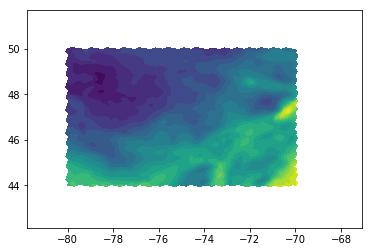

In [67]:
nc1 = Dataset(outfile)
tasmax = nc1.variables['tasmax'][:]
lon = nc1.variables['lon'][:]
lat = nc1.variables['lat'][:]
plt.contourf(lon,lat,tasmax[1,:,:],20)

#####Looks good - We can see the the St-Lawrence valley (if you are familiar with Quebec geography)